![Py4Eng](img/logo.png)


# Machine learning with Scikit-learn: Classification
## Yoav Ram

## Supervised learning

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. 

$$
X \to Y
$$

There are two fundamental supervised learning problems: regression and classification.
In classification, we need to predict a (discrete) class.
In regression, we need to predict a number.

We start with classification. In this case, _X_ can be anything, and _Y_ is a category (cat, dog, etc.) encoded as an integer (0, 1, etc.)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)
import seaborn as sns
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

import sklearn.datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from yellowbrick.contrib.classifier import DecisionViz
from yellowbrick.classifier import confusion_matrix

print('pandas', pd.__version__, '(should be at least 0.24.2)')
import sklearn
print('scikit-learn', sklearn.__version__, '(should be at least 0.23.2)')
import yellowbrick
print('yellowbrick', yellowbrick.__version__, '(should be at least 1.2)')

sns.set(
    style='ticks',
    context='talk',
    palette='Set1'
)

pandas 1.3.4 (should be at least 0.24.2)
scikit-learn 1.0.1 (should be at least 0.23.2)
yellowbrick 1.3.post1 (should be at least 1.2)


[![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)](http://scikit-learn.org/)

*Scikit-learn* is a Python package for machine learning:

- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license

We will do [one of the many tutorials](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) from the *scikit-learn* website. 

All estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

Most often, `y` is a 1D array of length `n_samples`.

# Seeds dataset

[The seeds dataset](https://archive.ics.uci.edu/ml/datasets/seeds) is a classification task consisting in identifying 3 different cultivars of wheat (Kama, Rosa and Canadian) from their seed features.

![wheat](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Naked_and_hulled_wheat.jpg/320px-Naked_and_hulled_wheat.jpg)

Let's start by loading the dataset.

In [5]:
df = pd.read_csv('../data/seeds_dataset.txt', sep='\t')
df.head()

,area,perimeter,compactness,kernel_length,kernel_width,asymmetry,kernel_groove,cultivar
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
target_name = 'cultivar'
feature_names = list(df.columns)
feature_names.remove(target_name)


X = df[feature_names].values
y = df[target_name].values

**Training set and testing set.** 
While experimenting with any learning algorithm, it is important not to test the prediction of an estimator on the data used to fit the estimator as this would not be evaluating the performance of the estimator on new data. This is why datasets are often split into train and test data.

Split the dataset to train and test data using a random permutation - this is easily done with functions from the `model_selection` module, which has many methods to split datasets. We'll use a very simple one, `train_test_split` which just splits that data by sampling a fraction of the rows to the training set and the rest to the test set (without replacement).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

# Classification

The simplest possible classifier is the **nearest neighbor**: given a new observation, find in the training set (i.e. the data used to train the estimator) the observation with the closest feature vector.

For example, if we have examples of red triangles and blue squares, how would we classify the green circle? Is it a triangle or a square?

![KNN](img/knn.png)

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

Import the nearest-neighbor classifier, then create and fit it:

In [6]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train) 

KNeighborsClassifier()

Predict the labels (cultivar) for the test data and compare with the real labels:

In [7]:
y_hat = classifier.predict(X_test)
print(y_hat)
print(y_test)
print('Accuracy:', classifier.score(X_test, y_test))

[1 2 1 1 3 2 2 2 2 3 1 3 1 3 2 2 3 1 1 1 3 1 1 1 2 1 2 1 3 3 2 3 1 2 3 3 3
 2 3 1 3 1 2 3 1 2 2 1 1 2 1 2 3 3 1 1 2 2 2 2 3 2 2 3 1 1 3 1 3 2]
[1 2 1 1 3 2 2 2 2 3 1 3 1 3 2 2 3 1 1 1 3 1 1 1 2 2 2 2 3 3 2 3 2 2 3 3 3
 2 1 2 3 1 2 3 1 2 2 1 1 2 1 2 3 3 1 1 2 2 2 2 3 2 2 1 1 1 1 1 3 2]
Accuracy: 0.9


# Reduce dimensions

To reduce the dimensionality of the problem (7 features - 7D) we can use *Seaborn*'s `pariplot` to look at the joint distributions of each pair of features.

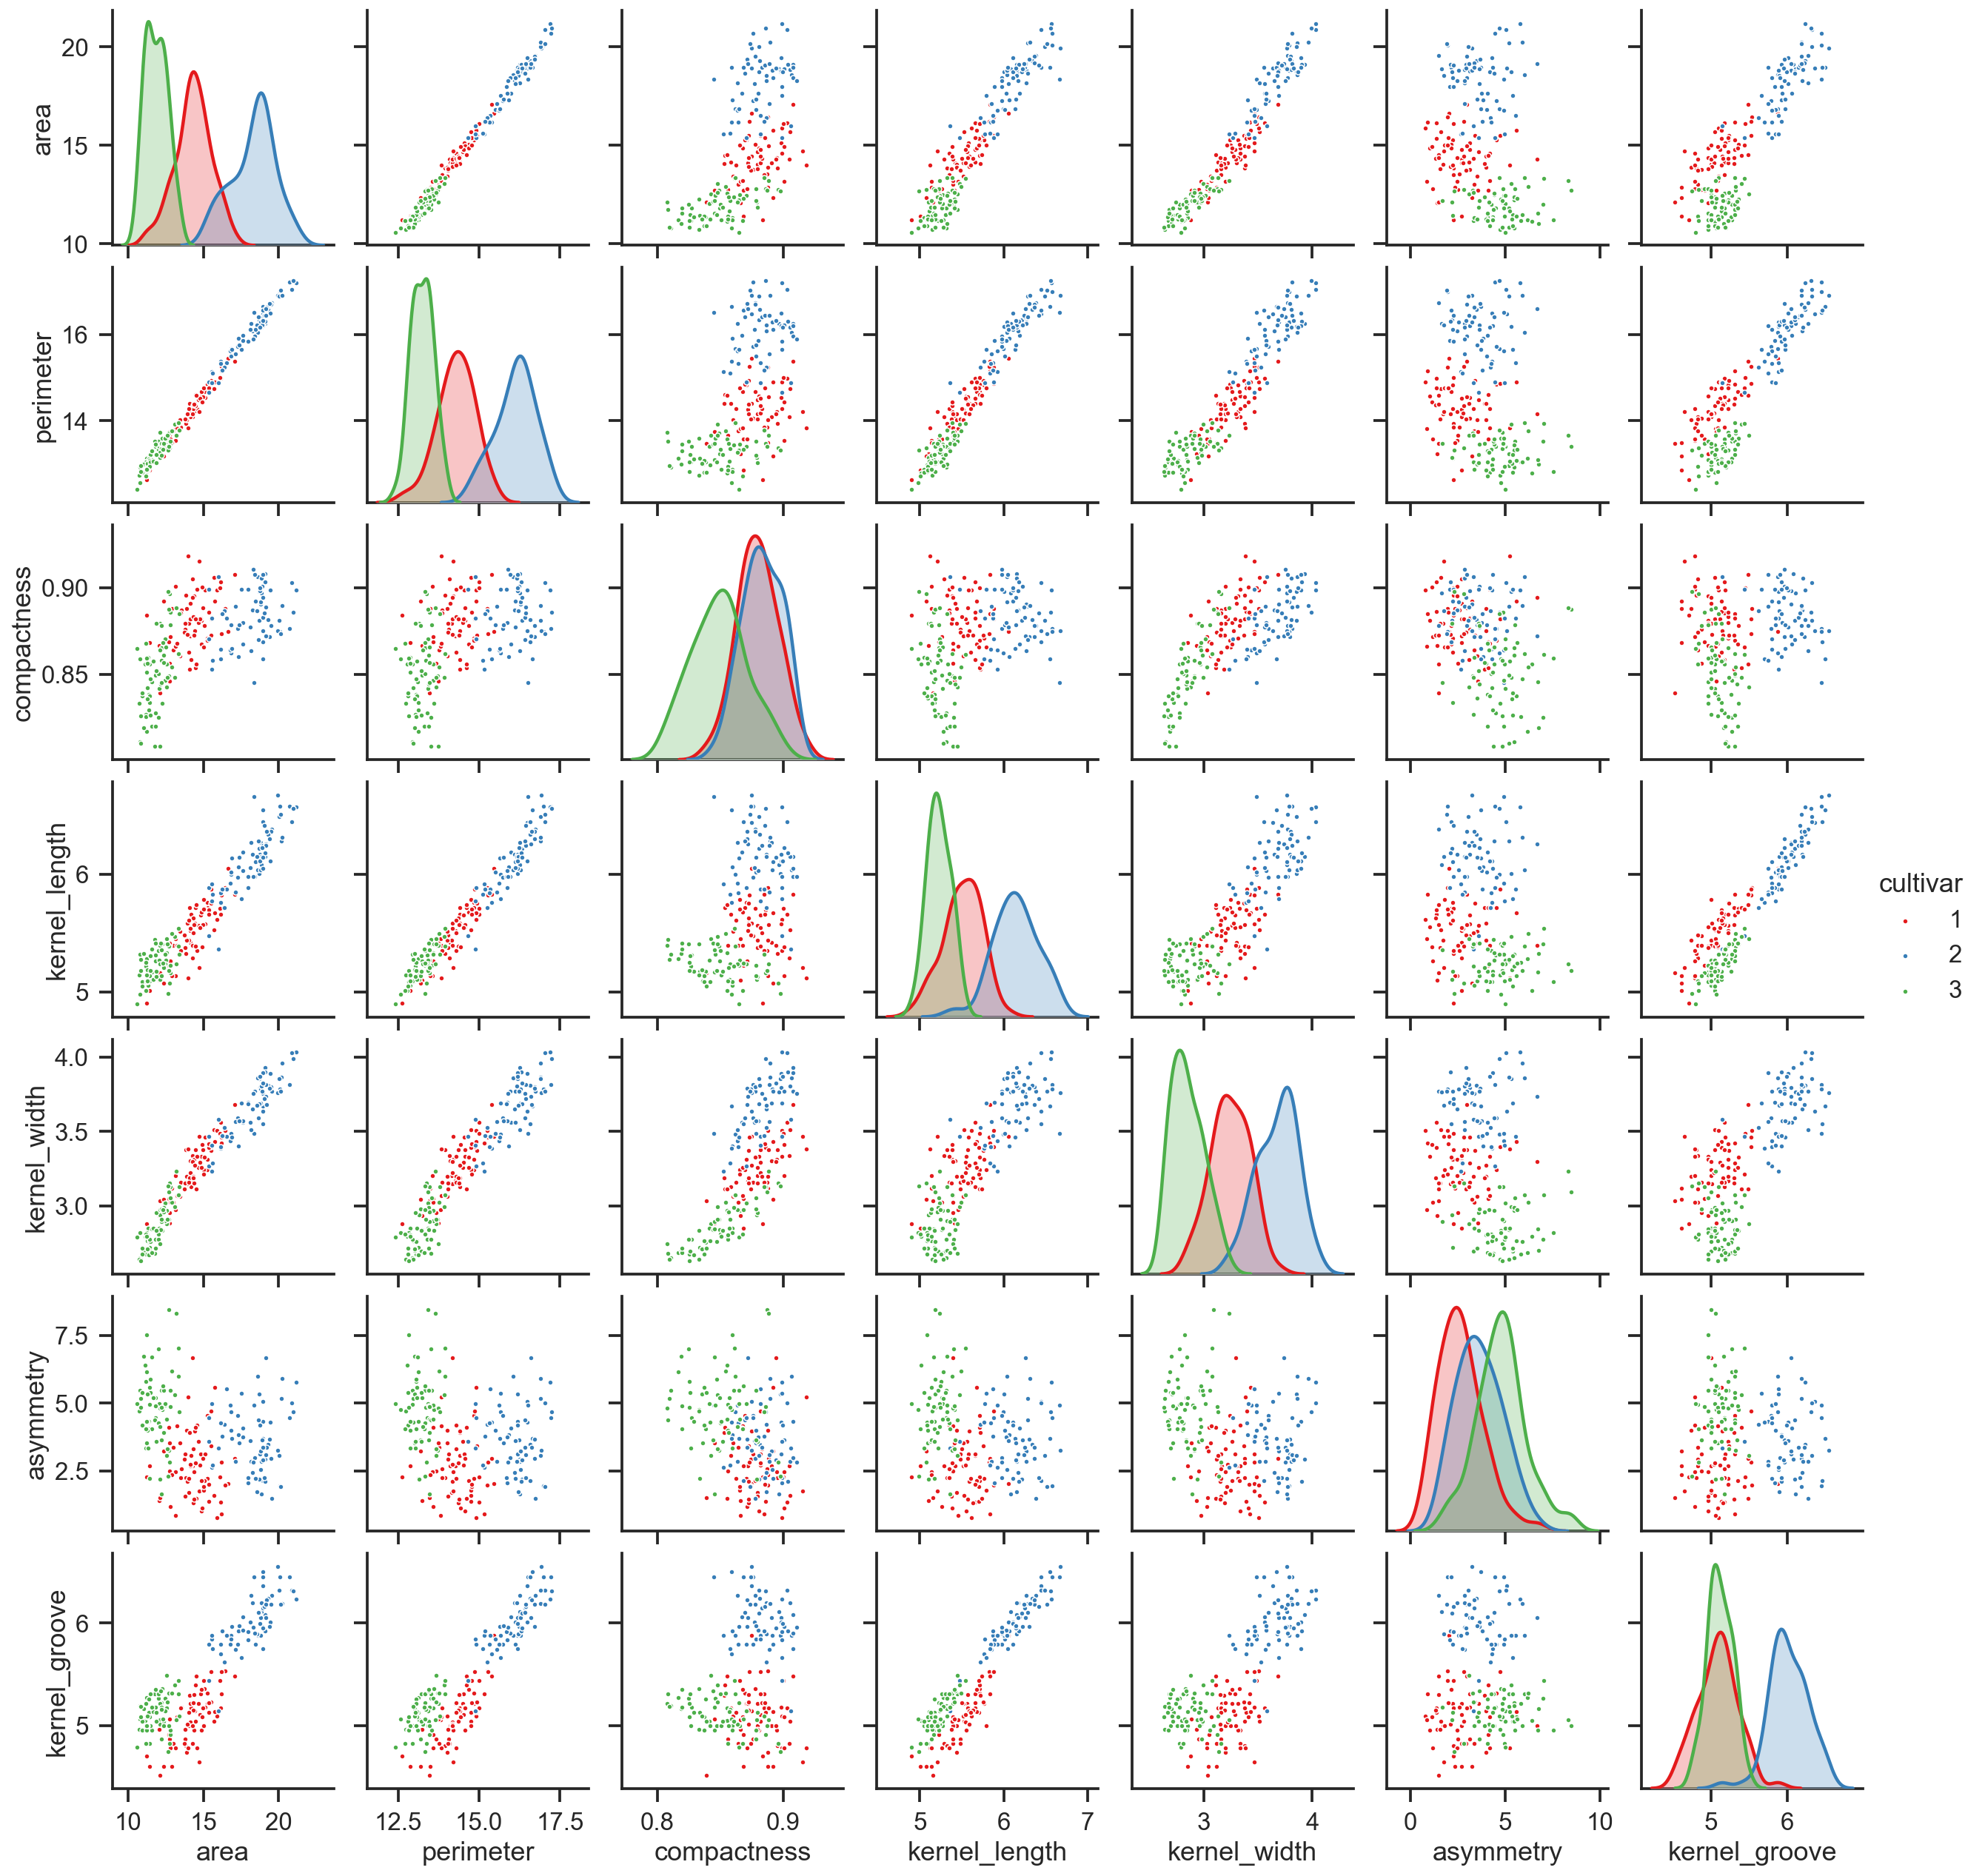

In [8]:
sns.pairplot(df, vars=feature_names, hue=target_name, 
             plot_kws={'s': 12});

From this figure it seems like using just the area and perimeter (first two columns in our features matrix) will do a produce a good separation between the cultivars.

Let's try it.

In [7]:
X_train = X_train[:, [3, 6]]
X_test = X_test[:, [3, 6]]

In [8]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)

y_hat = classifier.predict(X_test)
print(y_hat)
print(y_test)
print('Accuracy:', classifier.score(X_test, y_test))

[1 2 1 1 3 2 2 2 2 3 1 3 1 3 2 2 3 1 1 1 3 1 1 1 2 2 2 3 3 3 2 3 2 2 3 3 3
 2 3 3 3 1 2 3 1 2 2 1 1 2 1 2 3 3 2 3 2 2 2 2 3 2 2 3 1 1 1 1 3 2]
[1 2 1 1 3 2 2 2 2 3 1 3 1 3 2 2 3 1 1 1 3 1 1 1 2 2 2 2 3 3 2 3 2 2 3 3 3
 2 1 2 3 1 2 3 1 2 2 1 1 2 1 2 3 3 1 1 2 2 2 2 3 2 2 1 1 1 1 1 3 2]
Accuracy: 0.9142857142857143


That's nice! 

But as we are now in 2D, we can plot the classifier decision boundaries using [Yellowbrick](https://www.scikit-yb.org/en/latest/gallery.html)'s [decision boundaries](https://www.scikit-yb.org/en/latest/api/contrib/boundaries.html#decisionboundaries-vizualizer) visualizer.

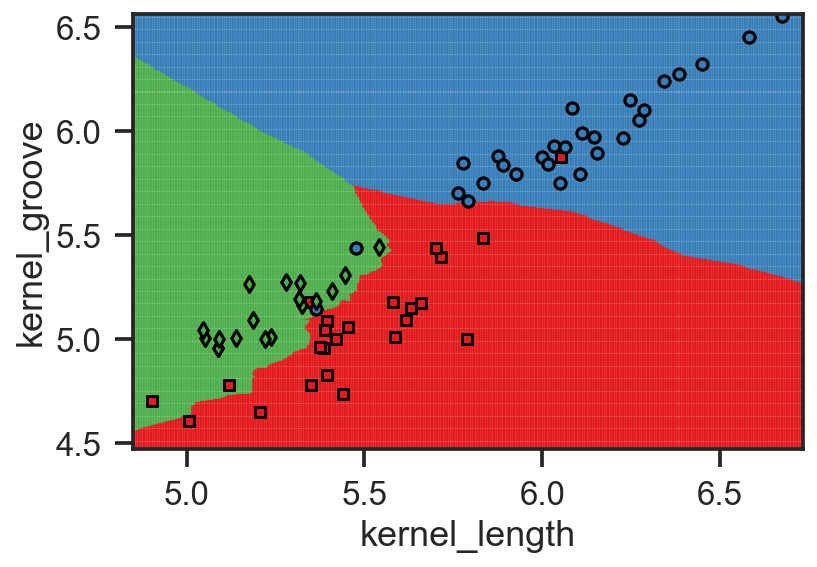

In [12]:
viz = DecisionViz(classifier,
                  markers='o', pcolormesh_alpha=0.7)
viz.fit(X_train, y_train)
viz.draw(X_test, y_test)
plt.xlabel(feature_names[3])
plt.ylabel(feature_names[6]);

# Exercise: Wine

The wine dataset contains 13 features and 3 target labels:

Features:
 - Alcohol
 - Malic acid
 - Ash
 - Alcalinity of ash  
 - Magnesium
 - Total phenols
 - Flavanoids
 - Nonflavanoid phenols
 - Proanthocyanins
 - Color intensity
 - Hue
 - OD280/OD315 of diluted wines
 - Proline

Classes (not very informative...):
 - class_0
 - class_1
 - class_2

In [6]:
X, y = sklearn.datasets.load_wine(return_X_y=True)

**Perform a train-test split and then train and score a classifier.**

You can use the KNN classifier we saw above, or you can experiment with [another classifier](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) -- some other classifiers are imported below.

In [14]:
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

Test accuracy: 0.9830508474576272


# Recognizing handwritten digits 

Learning to recognize handwritten digits with a K-nearest neighbors classifier, inspired by [IPython Interactive Computing and Visualization Cookbook](http://ipython-books.github.io/).

Start by looking at the data.

What do we have here?

In [7]:
X, y = sklearn.datasets.load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

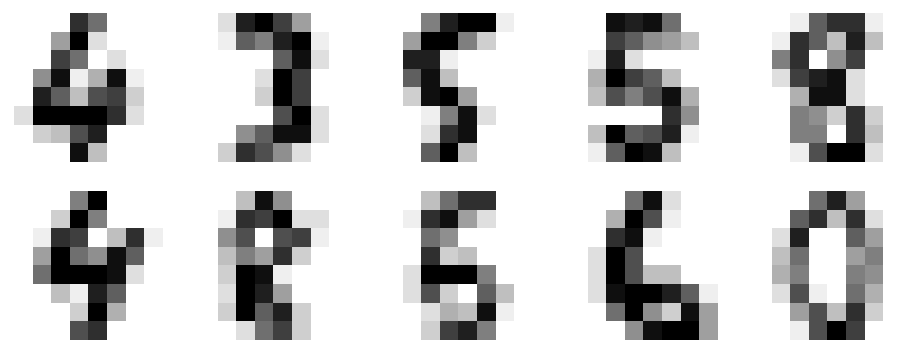

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax in axes.flat:
    idx = np.random.choice(np.arange(X.shape[0]))
    ax.matshow(X[idx].reshape(8, 8), cmap='gray_r')
    ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)

We can also look at the average image for each class, this should tell us if there is enonugh signal in the data to be learned from. 

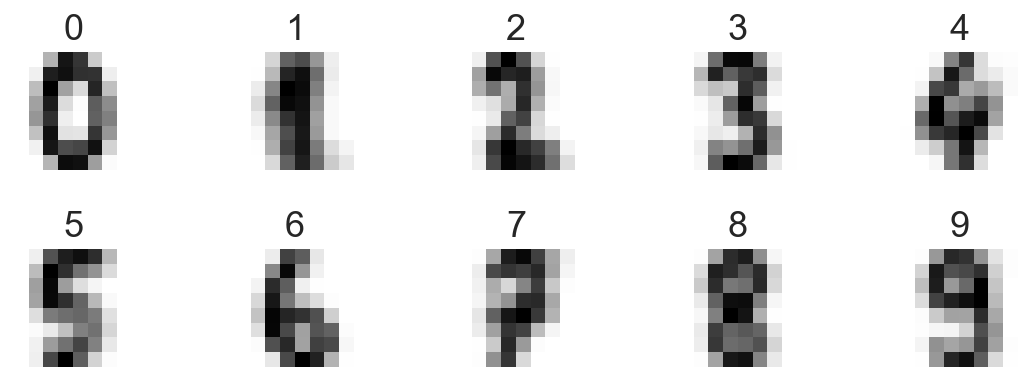

In [18]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for k, ax in enumerate(axes.flat):
    idx = y == k 
    X_k_mean = X[idx].mean(axis=0) 
    ax.imshow(X_k_mean.reshape((8, 8)), cmap='gray_r')
    ax.set(title=k, xticks=[], yticks=[])
sns.despine(bottom=True, left=True)
fig.tight_layout()

OK, so lets split the data and train a KNN classifier.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [20]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("Test accuracy: {:.4f}".format(knn.score(X_test, y_test)))

Test accuracy: 0.9764


## Confusion matrix

We can use [yellowbrick](https://www.scikit-yb.org/) to plot a [confusion matrix](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html) to understand where the confusion is: which classes are mistaken for which?

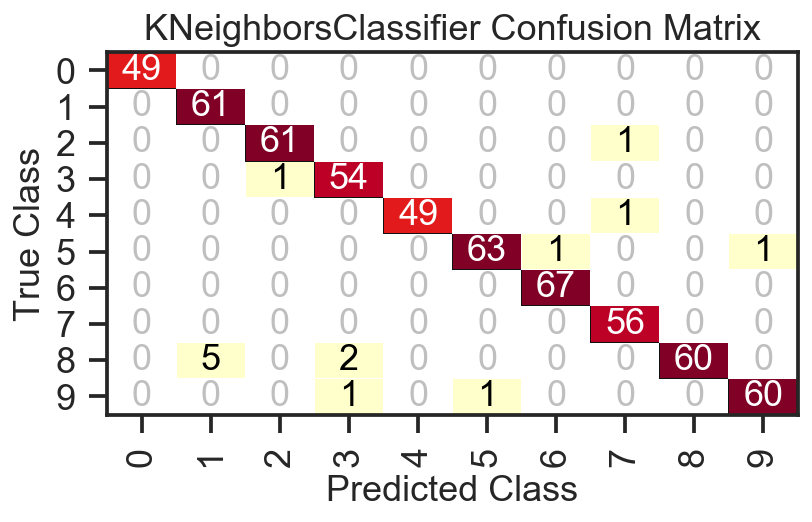

In [22]:
confusion_matrix(knn, X_train, y_train, X_test, y_test);

We can see that the most common mistake is that 8 are classified as 1, or sometimes 3.

# Logistic regression

Can we do any better with a different classifier?
Let's try the logistic regression classifer.
In this model, we try to estimate the probability $p_k$ that a data sample (image) belongs to class $k$ (digit $k$):
$$
p_k = \frac{1}{1+e^{-z_k}} \\
z_k = a_{1,k} x_1 + \ldots + a_{m,k} x_m
$$
where $x_j$ is pixel $j$ and $a_{j,k}$ is the increase in favor of class $k$ when pixel $j$ is dark.

In this case the loss function we minimize is *not* the sum of residual squares, but rather the **cross-entropy**:
$$
loss(p, y) = \sum_{i=1}^{n}{\sum_{k=0}^{9}{y_{i,k} \log{p_{i,k}}}}
$$
where $i$ is the image index ($n$ images overall), $k$ is the digit (i.e. class), $y_{i,k}=1$ if image $i$ is of digit $k$ and $y_{i,k}=0$ otherwise, and $p_{i,k}$ is the model prediction about the probability that image $i$ is of digit $k$.

In [25]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print("Test accuracy: {:.4f}".format(logistic.score(X_test, y_test)))

Test accuracy: 0.9596


## How does it work?

The figure below plots the values of the coefficeints $a_{j,k}$: for each digit $k$, there is one plot that shows the effect of each pixel. 

For example, in the top left plot pixels shown in red decrease the probability for a 0 class when dark, and pixels in blue increase the probability for a 0 class when dark.

(10, 64)


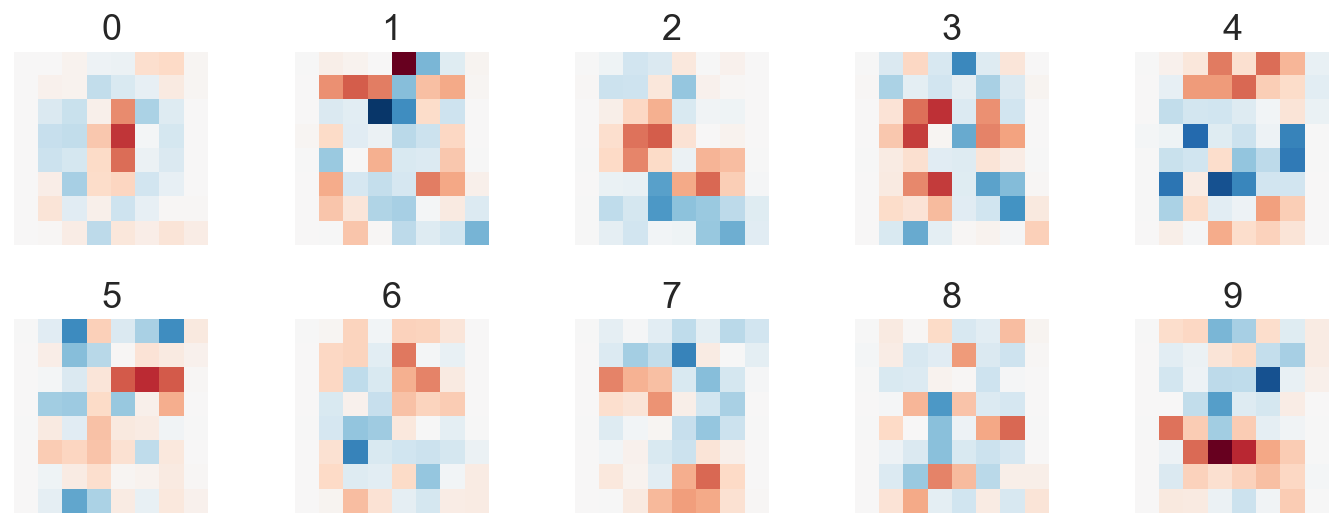

In [26]:
a = logistic.coef_
print(a.shape)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for k, ax in enumerate(axes.flat):
    ax.imshow(a[k, :].reshape((8, 8)), cmap='RdBu', vmin=-0.6, vmax=0.6)
    ax.set(title=k, xticks=[], yticks=[])
sns.despine(bottom=True, left=True)
fig.tight_layout()

## Exercise: neural network

Try other classifiers on the digits dataset.
For example, how about a neural network from `sklearn.neural_network`?

In [27]:
from sklearn import neural_network

Test accuracy: 0.9815


# References

- Scikit-learn [supervised learning tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).
- [Tuning meta-parameters](http://scikit-learn.org/stable/modules/grid_search.html#grid-search) with cross validation.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)